Install Libraries

In [ ]:
# tensorflow utility
!pip install -q tensorflow_io==0.21.0
!pip install -q tensorflow_probability==0.14.1
!pip install -q tensorflow_addons==0.22.0

# audio classification models
!pip install -q audio_classification_models

ERROR: Ignored the following versions that require a different python version: 0.23.0 Requires-Python >=3.6, <3.10
ERROR: Could not find a version that satisfies the requirement tensorflow_io==0.21.0 (from versions: 0.23.1, 0.24.0, 0.25.0, 0.26.0, 0.27.0, 0.28.0, 0.29.0, 0.30.0, 0.31.0, 0.32.0, 0.33.0, 0.34.0)
ERROR: No matching distribution found for tensorflow_io==0.21.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow-io
!pip install --upgrade typing-extensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0


In [ ]:
!pip install --upgrade tensorflow-addons tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.22.0
    Uninstalling tensorflow-addons-0.22.0:
      Successfully uninstalled tensorflow-addons-0.22.0


In [ ]:
!pip install --upgrade tensorflow_probability

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_probability
    Found existing installation: tensorflow-probability 0.14.1
    Uninstalling tensorflow-probability-0.14.1:
      Successfully uninstalled tensorflow-probability-0.14.1


In [ ]:
pip install --upgrade tensorflow

In [ ]:
pip install "librosa==0.9.1"

Import Libraries

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

import random

import cv2
#plt.rcParams["font.family"] = 'DejaVu Sans'
import seaborn as sns
#sns.set_style("whitegrid", {'axes.grid' : False})

import tensorflow as tf, re, math
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow_io as tfio
import tensorflow_probability as tfp

import yaml
from IPython import display as ipd
import json
from datetime import datetime

from glob import glob
from tqdm.notebook import tqdm
import sklearn
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from IPython import display as ipd

import itertools
import scipy
import warnings

# Show less log messages
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

Configuration

In [ ]:
directory_location= '/content/drive/Othercomputers/My laptop/DS_10283_3336/LA/LA'
FOLDS = 10
SEED = 101
DEBUG = True

# Audio params
Sample_Rate = 16000 #sample_rate
du = 5.0 # duration in second
audio_len = int(Sample_Rate * du)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = audio_len//(SPEC_WIDTH - 1) # non-overlap region
fr_max = Sample_Rate//2 # max frequency
SPEC_SHAPE = [SPEC_WIDTH, N_MELS] # output spectrogram shape

In [ ]:
class CFG:
    debug = False

    # Use verbose=0 for silent, 1 for interactive
    verbose = 0
    display_plot = True

    # Device for training
    device = None  # device is automatically selected

    # Model & Backbone
    model_name = "Conformer"

    # Seeding for reproducibility
    seed = 101

    # Audio params
    sample_rate = 16000
    duration = 3.5 # duration in second
    audio_len = int(sample_rate * duration)
    normalize = True

    # Spectrogram params
    spec_freq = 128 # freq axis
    n_fft = 2048
    spec_time = 256 # time axis
    hop_len = audio_len//(spec_time - 1) # non-overlap region
    fmin = 20
    fmax = sample_rate//2 # max frequency
    spec_shape = [spec_time, spec_freq] # output spectrogram shape

    # Audio Augmentation
    timeshift_prob = 0.0
    gn_prob = 0.0

    # Spectrogram Augmentation
    time_mask = 20
    freq_mask = 10
    cutmix_prob = 0.0
    cutmix_alpha = 2.5
    mixup_prob = 0.0
    mixup_alpha = 2.5

    # Batch Size & Epochs
    batch_size = 32
    drop_remainder = False
    epochs = 12
    steps_per_execution = None

    # Loss & Optimizer & LR Scheduler
    loss = "binary_crossentropy"
    optimizer = "Adam"
    lr = 1e-4
    lr_schedule = "cosine"

    # Augmentation
    augment = False

    # Clip values to [0, 1]
    clip = False

Reproducibility

In [ ]:
def seeding(SEED):
    """
    Sets all random seeds for the program (Python, NumPy, and TensorFlow).
    """
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
#     os.environ["TF_CUDNN_DETERMINISTIC"] = str(SEED)
    tf.random.set_seed(SEED)
    print("***seeding done***")


seeding(CFG.seed)

***seeding done***


Setup Device

In [ ]:
def configure_device():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # connect to tpu cluster
        strategy = tf.distribute.TPUStrategy(tpu) # get strategy for tpu
        print('> Running on TPU ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device='TPU'
    except: # otherwise detect GPUs
        tpu = None
        gpus = tf.config.list_logical_devices('GPU') # get logical gpus
        ngpu = len(gpus)
        if ngpu: # if number of GPUs are 0 then CPU
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy() # connect to single gpu or cpu
            device='CPU'
    return strategy, device, tpu

In [ ]:
strategy, CFG.device, tpu = configure_device()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

> Running on CPU
REPLICAS: 1


Meta Data

Train Sample

In [ ]:
#directory_location = '/content/drive/Othercomputers/My laptop/DS_10283_3336/LA/LA'

# Train
train_df = pd.read_csv(f'{directory_location}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt', sep=" ", header=None)
train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)
train_df['filepath'] = f'{directory_location}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32') # set labels 1 for fake and 0 for real
if True:
    train_df = train_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Train-Samples: {len(train_df)}')
train_df.head(5)

Train-Samples: 5000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_6200206,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
1,LA_0085,LA_T_6638771,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
2,LA_0098,LA_T_1236840,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
3,LA_0079,LA_T_6492747,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
4,LA_0095,LA_T_6999716,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0


Valid Sample

In [ ]:
valid_df = pd.read_csv(f'{directory_location}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt', sep=" ", header=None)
valid_df.columns =['speaker_id','filename','system_id','null','class_name']
valid_df.drop(columns=['null'],inplace=True)
valid_df['filepath'] = f'{directory_location}/ASVspoof2019_LA_dev/flac/'+valid_df.filename+'.flac'
valid_df['target'] = (valid_df.class_name=='spoof').astype('int32')
if DEBUG:
    valid_df = valid_df.groupby(['target']).sample(2000).reset_index(drop=True)
print(f'Valid Samples: {len(valid_df)}')
valid_df.head(5)

Valid Samples: 4000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0107,LA_D_4766808,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
1,LA_0102,LA_D_5136646,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
2,LA_0099,LA_D_2423683,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
3,LA_0106,LA_D_4106360,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
4,LA_0070,LA_D_7870292,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0


Test Sample

In [ ]:
test_df = pd.read_csv(f'{directory_location}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt', sep=" ", header=None)
test_df.columns =['speaker_id','filename','system_id','null','class_name']
test_df.drop(columns=['null'],inplace=True)
test_df['filepath'] = f'{directory_location}/ASVspoof2019_LA_eval/flac/'+test_df.filename+'.flac'
test_df['target'] = (test_df.class_name=='spoof').astype('int32')
if DEBUG:
    test_df = test_df.groupby(['target']).sample(2000).reset_index(drop=True)
print(f'Test Samples: {len(test_df)}')
test_df.head(5)

Test Samples: 4000


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0050,LA_E_5269639,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
1,LA_0033,LA_E_8296129,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
2,LA_0042,LA_E_8189830,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
3,LA_0012,LA_E_7841713,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0
4,LA_0012,LA_E_3579281,-,bonafide,/content/drive/Othercomputers/My laptop/DS_102...,0


Utilities

In [ ]:
def load_audio(path, sr=16000):
    audio, sr = librosa.load(path, sr=sr)
    return audio, sr

def plot_audio(audio, sr=16000):
    fig = librosa.display.waveshow(audio, x_axis='time', sr=sr)
    return fig

def listen_audio(audio, sr=16000):
    display(ipd.Audio(audio, rate=sr))

def get_spec(audio):
    spec = librosa.feature.melspectrogram(audio, fmax=fr_max, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
    spec = librosa.power_to_db(spec)
    return spec

def plot_spec(spec, sr=16000, cmap='viridis'):
    fig = librosa.display.specshow(spec, x_axis='time', y_axis='hz', hop_length=HOP_LEN, sr=Sample_Rate, fmax=fr_max, cmap=cmap)
    return fig

Visualizing Samples:
Real / Genuine Audio Sample

> Filename: LA_T_2437964 | Label: bonafide
# Listen


# Plot



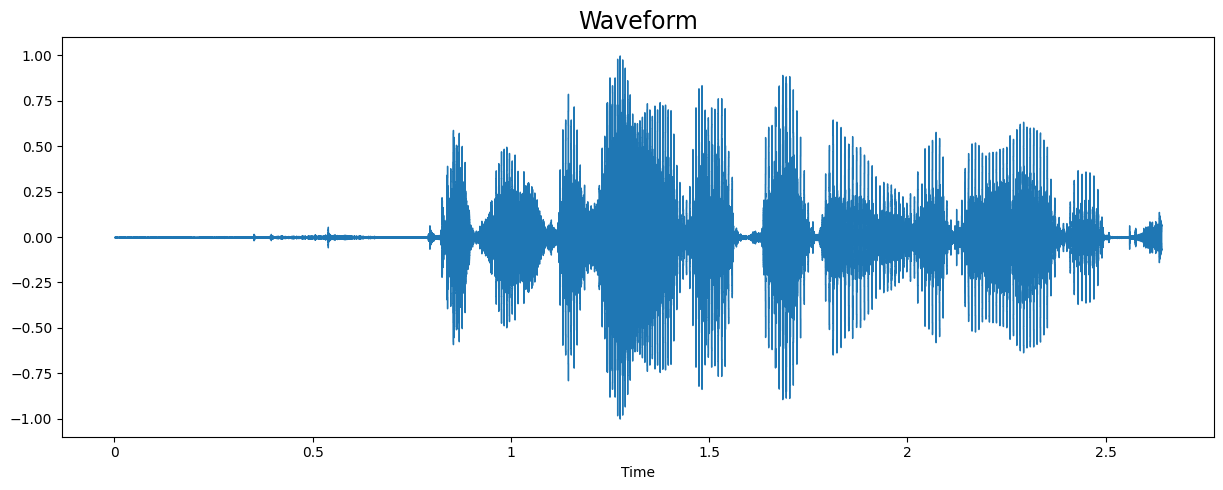

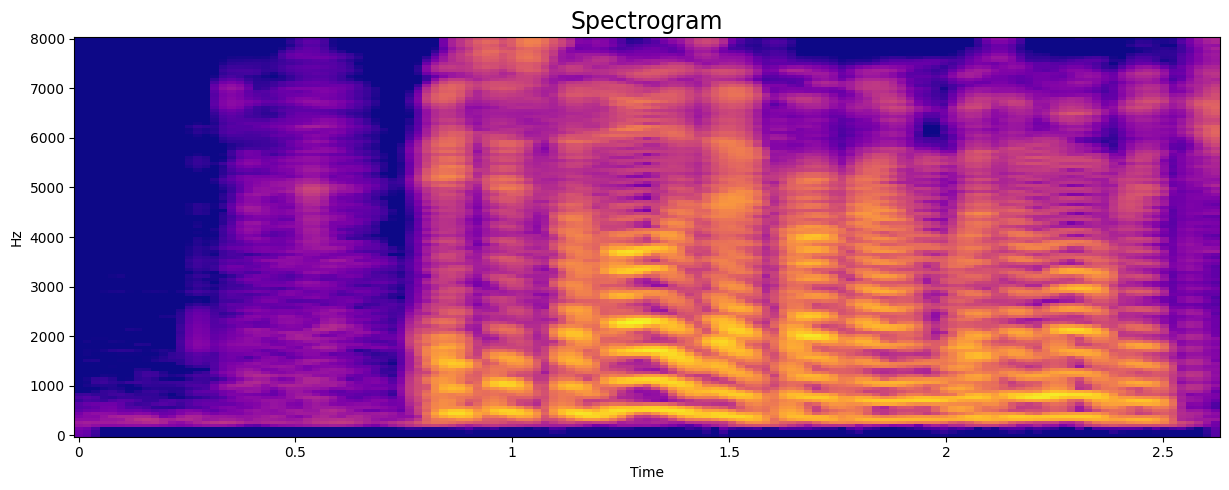

In [ ]:
row = train_df[train_df.target==0].iloc[20]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:audio_len]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
#Waveform
plt.figure(figsize=(12*2,5))
plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)
plt.tight_layout()

#Spectrogram
plt.figure(figsize=(12*2,5))
plt.subplot(122)
plot_spec(spec, cmap='plasma');
plt.title("Spectrogram",fontsize=17)
plt.tight_layout()

plt.show()

Fake / Synthetic Speech Audio Sample

Filename: LA_T_6706091 | Label: spoof
# Listen


# Plot



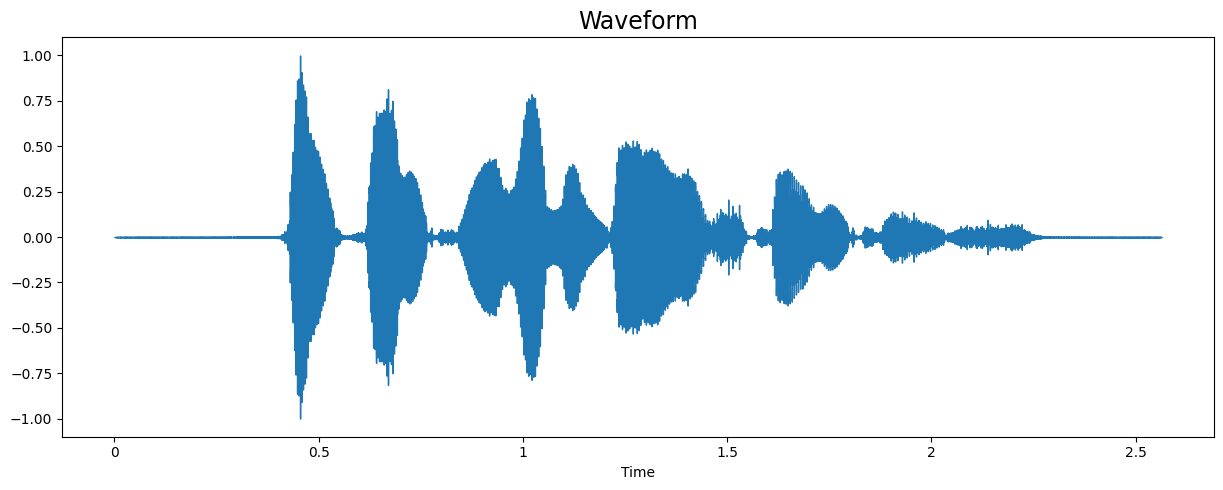

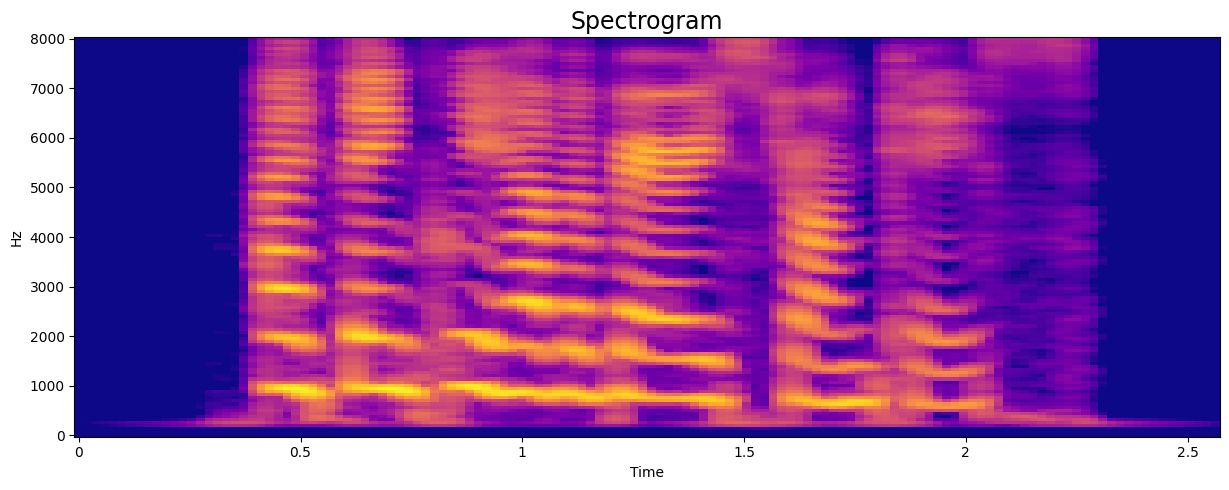

In [ ]:
row = train_df[train_df.target==1].iloc[20]
print(f'Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:audio_len]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
#Waveform
plt.figure(figsize=(12*2,5))
plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)
plt.tight_layout()

#Spectrogram
plt.figure(figsize=(12*2,5))
plt.subplot(122)
plot_spec(spec, cmap='plasma');
plt.title("Spectrogram",fontsize=17)
plt.tight_layout()

plt.show()

Splitting Data into folds

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Split train data into folds
for fold, (_, val_idx) in enumerate(skf.split(train_df, y=train_df['target'])):
    train_df.loc[val_idx, 'fold'] = fold

# Split valid data into folds
for fold, (_, val_idx) in enumerate(skf.split(valid_df, y=valid_df['target'])):
    valid_df.loc[val_idx, 'fold'] = fold

# Split test data into folds
for fold, (_, val_idx) in enumerate(skf.split(test_df, y=test_df['target'])):
    test_df.loc[val_idx, 'fold'] = fold

display(test_df.groupby(['fold','target']).size())

fold  target
0.0   0         200
      1         200
1.0   0         200
      1         200
2.0   0         200
      1         200
3.0   0         200
      1         200
4.0   0         200
      1         200
5.0   0         200
      1         200
6.0   0         200
      1         200
7.0   0         200
      1         200
8.0   0         200
      1         200
9.0   0         200
      1         200
dtype: int64

In [ ]:
train_df.fold.value_counts()

9.0    500
0.0    500
1.0    500
4.0    500
7.0    500
3.0    500
5.0    500
8.0    500
6.0    500
2.0    500
Name: fold, dtype: int64

Creating tfrecord data

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def train_serialize_example(feature0, feature1, feature2, feature3, feature4,feature5,feature6):
    feature = {'audio':_bytes_feature(feature0),
               'id':_bytes_feature(feature1),
               'speaker_id':_bytes_feature(feature2),
               'system_id':_bytes_feature(feature3),
               'class_name':_bytes_feature(feature4),
               'audio_len':_int64_feature(feature5),
               'target':_int64_feature(feature6)
  }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [ ]:
#Create a directory to write the tfrecord files
os.makedirs('/content/drive/Othercomputers/My laptop/DS_10283_3336/tmp_LA', exist_ok=True)

In [ ]:
#Create a function to write_tfrecord
def write_tfrecord(df, split='train', show=True):
    df = df.copy()
    folds = sorted(df.fold.unique().tolist())
    for fold in tqdm(folds): # create tfrecord for each fold
        fold_df = df.query("fold==@fold").sample(frac=1.0)
        if show:
            print(); print('Writing %s TFRecord for fold %i :'%(split,fold))
        with tf.io.TFRecordWriter('/content/drive/Othercomputers/My laptop/DS_10283_3336/tmp_LA/%s%.2i-%i.tfrec'%(split,fold,fold_df.shape[0])) as writer:
            samples = fold_df.shape[0] # samples = 200
            it = tqdm(range(samples)) if show else range(samples)
            for k in it: # images in fold
                row = fold_df.iloc[k,:]
                audio, sr = load_audio(row['filepath'])
                audio_id = row['filename']
                speaker_id = row['speaker_id']
                system_id = row['system_id']
                class_name = row['class_name']
                target = row['target']
                example  = train_serialize_example(
                    tf.audio.encode_wav(audio[...,None],sample_rate=sr),
                    str.encode(audio_id),
                    str.encode(speaker_id),
                    str.encode(system_id),
                    str.encode(class_name),
                    len(audio),
                    int(target),
                    )
                writer.write(example)
            if show:
                filepath = '/content/drive/Othercomputers/My laptop/DS_10283_3336/tmp_LA/%s%.2i-%i.tfrec'%(split,fold,fold_df.shape[0])
                filename = filepath.split('/')[-1]
                filesize = os.path.getsize(filepath)/10**6
                print(filename,':',np.around(filesize, 2),'MB')

Train dataset tfrecord

In [ ]:
write_tfrecord(train_df,split='train', show=True)

  0%|          | 0/10 [00:00<?, ?it/s]


Writing train TFRecord for fold 0 :


  0%|          | 0/500 [00:00<?, ?it/s]

train00-500.tfrec : 54.65 MB

Writing train TFRecord for fold 1 :


  0%|          | 0/500 [00:00<?, ?it/s]

train01-500.tfrec : 54.49 MB

Writing train TFRecord for fold 2 :


  0%|          | 0/500 [00:00<?, ?it/s]

train02-500.tfrec : 54.36 MB

Writing train TFRecord for fold 3 :


  0%|          | 0/500 [00:00<?, ?it/s]

train03-500.tfrec : 54.67 MB

Writing train TFRecord for fold 4 :


  0%|          | 0/500 [00:00<?, ?it/s]

train04-500.tfrec : 53.8 MB

Writing train TFRecord for fold 5 :


  0%|          | 0/500 [00:00<?, ?it/s]

train05-500.tfrec : 54.31 MB

Writing train TFRecord for fold 6 :


  0%|          | 0/500 [00:00<?, ?it/s]

train06-500.tfrec : 54.58 MB

Writing train TFRecord for fold 7 :


  0%|          | 0/500 [00:00<?, ?it/s]

train07-500.tfrec : 53.96 MB

Writing train TFRecord for fold 8 :


  0%|          | 0/500 [00:00<?, ?it/s]

train08-500.tfrec : 55.66 MB

Writing train TFRecord for fold 9 :


  0%|          | 0/500 [00:00<?, ?it/s]

train09-500.tfrec : 54.59 MB


Valid Dataset tfrecord

In [ ]:
write_tfrecord(valid_df,split='valid', show=True)

  0%|          | 0/10 [00:00<?, ?it/s]


Writing valid TFRecord for fold 0 :


  0%|          | 0/400 [00:00<?, ?it/s]

valid00-400.tfrec : 46.46 MB

Writing valid TFRecord for fold 1 :


  0%|          | 0/400 [00:00<?, ?it/s]

valid01-400.tfrec : 44.35 MB

Writing valid TFRecord for fold 2 :


  0%|          | 0/400 [00:00<?, ?it/s]

valid02-400.tfrec : 44.61 MB

Writing valid TFRecord for fold 3 :


  0%|          | 0/400 [00:00<?, ?it/s]

valid03-400.tfrec : 44.04 MB

Writing valid TFRecord for fold 4 :


  0%|          | 0/400 [00:00<?, ?it/s]

valid04-400.tfrec : 44.11 MB

Writing valid TFRecord for fold 5 :


  0%|          | 0/400 [00:00<?, ?it/s]

valid05-400.tfrec : 46.42 MB

Writing valid TFRecord for fold 6 :


  0%|          | 0/400 [00:00<?, ?it/s]

valid06-400.tfrec : 45.97 MB

Writing valid TFRecord for fold 7 :


  0%|          | 0/400 [00:00<?, ?it/s]

valid07-400.tfrec : 45.47 MB

Writing valid TFRecord for fold 8 :


  0%|          | 0/400 [00:00<?, ?it/s]

valid08-400.tfrec : 44.73 MB

Writing valid TFRecord for fold 9 :


  0%|          | 0/400 [00:00<?, ?it/s]

valid09-400.tfrec : 43.74 MB


Test Dataset tfrecord

In [ ]:
write_tfrecord(test_df,split='test', show=True)

  0%|          | 0/10 [00:00<?, ?it/s]


Writing test TFRecord for fold 0 :


  0%|          | 0/400 [00:00<?, ?it/s]

test00-400.tfrec : 41.32 MB

Writing test TFRecord for fold 1 :


  0%|          | 0/400 [00:00<?, ?it/s]

test01-400.tfrec : 41.25 MB

Writing test TFRecord for fold 2 :


  0%|          | 0/400 [00:00<?, ?it/s]

test02-400.tfrec : 40.13 MB

Writing test TFRecord for fold 3 :


  0%|          | 0/400 [00:00<?, ?it/s]

test03-400.tfrec : 41.62 MB

Writing test TFRecord for fold 4 :


  0%|          | 0/400 [00:00<?, ?it/s]

test04-400.tfrec : 42.52 MB

Writing test TFRecord for fold 5 :


  0%|          | 0/400 [00:00<?, ?it/s]

test05-400.tfrec : 42.07 MB

Writing test TFRecord for fold 6 :


  0%|          | 0/400 [00:00<?, ?it/s]

test06-400.tfrec : 41.61 MB

Writing test TFRecord for fold 7 :


  0%|          | 0/400 [00:00<?, ?it/s]

test07-400.tfrec : 41.62 MB

Writing test TFRecord for fold 8 :


  0%|          | 0/400 [00:00<?, ?it/s]

test08-400.tfrec : 41.8 MB

Writing test TFRecord for fold 9 :


  0%|          | 0/400 [00:00<?, ?it/s]

test09-400.tfrec : 41.58 MB


In [ ]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
TRAIN_FILENAMES = tf.io.gfile.glob('/content/drive/Othercomputers/My laptop/DS_10283_3336/tmp_LA/train*.tfrec')
VALID_FILENAMES = tf.io.gfile.glob('/content/drive/Othercomputers/My laptop/DS_10283_3336/tmp_LA/valid*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob('/content/drive/Othercomputers/My laptop/DS_10283_3336/tmp_LA/test*.tfrec')

print('# NUM TRAIN: {:,}'.format(count_data_items(TRAIN_FILENAMES)))
print('# NUM VALID: {:,}'.format(count_data_items(VALID_FILENAMES)))
print('# NUM TEST: {:,}'.format(count_data_items(TEST_FILENAMES)))

# NUM TRAIN: 5,000
# NUM VALID: 4,000
# NUM TEST: 4,000


Utility

In [ ]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

Audio Augmentation

In [ ]:
# Trim Audio to ignore silent part in the start and end
def TrimAudio(audio, epsilon=0.15):
    pos  = tfio.audio.trim(audio, axis=0, epsilon=epsilon)
    audio = audio[pos[0]:pos[1]]
    return audio

# Crop or Pad audio to keep a fixed length
def CropOrPad(audio, target_len, pad_mode='constant'):
    audio_len = tf.shape(audio)[0]
    if audio_len < target_len: # if audio_len is smaller than target_len then use Padding
        diff_len = (target_len - audio_len)
        pad1 = random_int([], minval=0, maxval=diff_len) # select random location for padding
        pad2 = diff_len - pad1
        pad_len = [pad1, pad2]
        audio = tf.pad(audio, paddings=[pad_len], mode=pad_mode) # apply padding
    elif audio_len > target_len:  # if audio_len is larger than target_len then use Cropping
        diff_len = (audio_len - target_len)
        idx = tf.random.uniform([], 0, diff_len, dtype=tf.int32) # select random location for cropping
        audio = audio[idx: (idx + target_len)]
    audio = tf.reshape(audio, [target_len])
    return audio

# Randomly shift audio -> any sound at <t> time may get shifted to <t+shift> time
def TimeShift(audio, prob=0.5):
    if random_float() < prob:
        shift = random_int(shape=[], minval=0, maxval=tf.shape(audio)[0])
        if random_float() < 0.5:
            shift = -shift
        audio = tf.roll(audio, shift, axis=0)
    return audio

# Apply random noise to audio data
def GaussianNoise(audio, std=[0.0025, 0.025], prob=0.5):
    std = random_float([], std[0], std[1])
    if random_float() < prob:
        GN = tf.keras.layers.GaussianNoise(stddev=std)
        audio = GN(audio, training=True) # training=False don't apply noise to data
    return audio

# Applies augmentation to Audio Signal
def AudioAug(audio):
    audio = TimeShift(audio, prob=CFG.timeshift_prob)
    audio = GaussianNoise(audio, prob=CFG.gn_prob)
    return audio

def Normalize(data):
    MEAN = tf.math.reduce_mean(data)
    STD = tf.math.reduce_std(data)
    data = tf.math.divide_no_nan(data - MEAN, STD)
    return data

Spectrogram Augmentation

In [ ]:
# Randomly mask data in time and freq axis
def TimeFreqMask(spec, time_mask, freq_mask, prob=0.5):
    if random_float() < prob:
        spec = tfio.audio.freq_mask(spec, param=freq_mask)
        spec = tfio.audio.time_mask(spec, param=time_mask)
    return spec

# Applies augmentation to Spectrogram
def SpecAug(spec):
    spec = TimeFreqMask(spec, time_mask=CFG.time_mask, freq_mask=CFG.freq_mask, prob=0.5)
    return spec

# Compute MixUp Augmentation for Spectrogram
def get_mixup(alpha=0.2, prob=0.5):
    """Apply Spectrogram-MixUp augmentaiton. Apply Mixup to one batch and its shifted version"""
    def mixup(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels

        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)

        beta = tfp.distributions.Beta(alpha, alpha) # select lambda from beta distribution
        lam = beta.sample(1)[0]

        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs = lam * specs + (1 - lam) * tf.roll(specs, shift=1, axis=0) # mixup = [1, 2, 3]*lam + [3, 1, 2]*(1 - lam)
        labels = lam * labels + (1 - lam) * tf.roll(labels, shift=1, axis=0)

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)
        return specs, labels
    return mixup


def get_cutmix(alpha, prob=0.5):
    """Apply Spectrogram-CutMix augmentaiton which only cuts patch across time axis unline
    typical Computer-Vision CutMix. Apply CutMix to one batch and its shifted version.
    """
    def cutmix(specs, labels, alpha=alpha, prob=prob):
        if random_float() > prob:
            return specs, labels
        spec_shape = tf.shape(specs)
        label_shape = tf.shape(labels)
        W = tf.cast(spec_shape[1], tf.int32)  # [batch, time, freq, channel]

        # Lambda from beta distribution
        beta = tfp.distributions.Beta(alpha, alpha)
        lam = beta.sample(1)[0]

        # It's faster to roll the batch by one instead of shuffling it to create image pairs
        specs_rolled = tf.roll(specs, shift=1, axis=0) # specs->[1, 2, 3], specs_rolled->[3, 1, 2]
        labels_rolled = tf.roll(labels, shift=1, axis=0)

        # Select random patch size
        r_x = random_int([], minval=0, maxval=W)
        r = 0.5 * tf.math.sqrt(1.0 - lam)
        r_w_half = tf.cast(r * tf.cast(W, tf.float32), tf.int32)

        # Select random location in time axis
        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, W), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, W), tf.int32)

        # outer-pad patch -> [0, 0, x, x, 0, 0]
        patch1 = specs[:, x1:x2, :, :]  # [batch, time, freq, channel]
        patch1 = tf.pad(
            patch1, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad

        # inner-pad-patch -> [y, y, 0, 0, y, y]
        patch2 = specs_rolled[:, x1:x2, :, :]  # [batch, mel, time, channel]
        patch2 = tf.pad(
            patch2, [[0, 0], [x1, W - x2], [0, 0], [0, 0]])  # outer-pad
        patch2 = specs_rolled - patch2  # inner-pad-patch = img - outer-pad-patch

        # patch1 -> [0, 0, x, x, 0, 0], patch2 -> [y, y, 0, 0, y, y]
        # cutmix = (patch1 + patch2) -> [y, y, x, x, y, y]
        specs = patch1 + patch2  # cutmix img

        # Compute lambda = [1 - (patch_area/image_area)]
        lam = tf.cast((1.0 - (x2 - x1) / (W)),tf.float32)  # no H term as (y1 - y2) = H
        labels = lam * labels + (1.0 - lam) * labels_rolled  # cutmix label

        specs = tf.reshape(specs, spec_shape)
        labels = tf.reshape(labels, label_shape)

        return specs, labels
    return cutmix

Mel-Spectogram

In [ ]:
# Compute Spectrogram from audio
def Audio2Spec(audio,spec_shape=[256, 128],sr=16000,nfft=2048,window=2048,fmin=20,fmax=8000):
    spec_time = spec_shape[0]
    spec_freq = spec_shape[1]
    audio_len = tf.shape(audio)[0]
    hop_length = tf.cast((audio_len // (spec_time - 1)), tf.int32) # compute hop_length to keep desired spec_shape
    spec = tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=hop_length) # convert to spectrogram
    mel_spec = tfio.audio.melscale(spec, rate=sr, mels=spec_freq, fmin=fmin, fmax=fmax) # transform to melscale
    db_mel_spec = tfio.audio.dbscale(mel_spec, top_db=80) # from power to db (log10) scale
    if tf.shape(db_mel_spec)[0] > spec_time:  # check if we have desiered shape
        db_mel_spec = db_mel_spec[:spec_time,:]
    db_mel_spec = tf.reshape(db_mel_spec, spec_shape)
    return db_mel_spec

# Convert spectrogram (H,W) to image (H,W,1)
def Spec2Img(spec, num_channels=1):
    # 1 channel image
    img = spec[..., tf.newaxis]
    # Copy same image across channel axis
    if num_channels>1:
        img = tf.tile(img, [1, 1, num_channels])
    return img

Data Pipeline
Reading TFRecord Data

In [ ]:
def decode_audio(data, audio_len):
    # Decode
    audio, sr = tf.audio.decode_wav(data)
    audio = tf.reshape(audio, [audio_len]) # explicit size needed for TPU
    audio = tf.cast(audio,tf.float32)
    # Normalization
    if CFG.normalize:
        audio = Normalize(audio)
    return audio

# Decode label
def decode_label(label):
    label = tf.cast(label, tf.float32)
    return label

# Read tfrecord data & parse it & do augmentation
def read_tfrecord(example, augment=True, return_id=False, return_label=True, target_len=CFG.audio_len, spec_shape=CFG.spec_shape):
    tfrec_format = {
        "audio" : tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id" : tf.io.FixedLenFeature([], tf.string),
        "speaker_id": tf.io.FixedLenFeature([], tf.string),
        "system_id" : tf.io.FixedLenFeature([], tf.string),
        "audio_len" : tf.io.FixedLenFeature([], tf.int64),
        "target" : tf.io.FixedLenFeature([], tf.int64),
    }
    # Parses a single example proto.
    example = tf.io.parse_single_example(
        example, tfrec_format
    )
    # Extract data from example proto
    audio_id = example["id"]
    audio_len = example["audio_len"]
    # Decoding
    audio = decode_audio(example["audio"], audio_len)  # decode audio from .wav
    target = decode_label(example["target"]) # decode label -> type cast
    # Trim Audio
    audio = TrimAudio(audio)
    # Crop or Pad audio to keep a fixed length
    audio = CropOrPad(audio, target_len)
    if augment:
        # Apply AudioAug
        audio = AudioAug(audio)
    # Compute Spectrogram
    spec = Audio2Spec(audio, spec_shape=spec_shape)
    if augment:
        # Apply SpecAug
        spec = SpecAug(spec)
    # Spectrogram (H, W) to Image (H, W, C)
    img = Spec2Img(spec, num_channels=1)
    # Clip & Reshape
    img = tf.clip_by_value(img, 0, 1) if CFG.clip else img
    img = tf.reshape(img, [*spec_shape, 1])

    if not return_id:
        if return_label:
            return (img, target)
        else:
            return img
    else:
        if return_label:
            return (img, target, audio_id)
        else:
            return (img, audio_id)

In [ ]:
def get_dataset(
    filenames,
    shuffle=True,
    repeat=True,
    augment=True,
    cache=True,
    return_id=False,
    return_label=True,
    batch_size=CFG.batch_size * REPLICAS,
    target_len=CFG.audio_len,
    spec_shape=CFG.spec_shape,
    drop_remainder=False,
    seed=CFG.seed,
):
    # Real tfrecord files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    if cache:
        dataset = dataset.cache()  # cache data for speedup
    if repeat:
        dataset = dataset.repeat()  # repeat the data (for training only)
    if shuffle:
        dataset = dataset.shuffle(1024, seed=seed)  # shuffle the data (for training only)
        options = tf.data.Options()
        options.experimental_deterministic = False  # order won't be maintained when we shuffle
        dataset = dataset.with_options(options)
    # Parse data from tfrecord
    dataset = dataset.map(lambda x: read_tfrecord(x,
                                                  augment=augment,
                                                  return_id=return_id,
                                                  return_label=return_label,
                                                  target_len=target_len,),
                          num_parallel_calls=AUTO,)
    # Batch Data Samples
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    # MixUp
    if CFG.mixup_prob and augment and return_label:
        dataset = dataset.map(get_mixup(alpha=CFG.mixup_alpha,prob=CFG.mixup_prob),num_parallel_calls=AUTO)
    # CutMix
    if CFG.cutmix_prob and augment and return_label:
        dataset = dataset.map(get_cutmix(alpha=CFG.cutmix_alpha,prob=CFG.cutmix_prob),num_parallel_calls=AUTO)
    # Prefatch data for speedup
    dataset = dataset.prefetch(AUTO)
    return dataset

Visualisation

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, save = False):
    """Plot Confusion Matrix"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    return

def plot_history(history):
    """Plot model training history"""
    plt.figure(figsize=(15, 5))
    plt.plot(
        np.arange(len(history["f1_score"])),
        history["f1_score"],
        "-o",
        label="Train f1_score",
        color="#ff7f0e",
    )
    plt.plot(
        np.arange(len(history["f1_score"])),
        history["val_f1_score"],
        "-o",
        label="Val f1_score",
        color="#1f77b4",
    )
    x = np.argmax(history["val_f1_score"])
    y = np.max(history["val_f1_score"])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=200, color="#1f77b4")
    plt.text(x - 0.03 * xdist, y - 0.13 * ydist, "max f1_score\n%.2f" % y, size=14)
    plt.ylabel("f1_score", size=14)
    plt.xlabel("Epoch", size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(
        np.arange(len(history["f1_score"])),
        history["loss"],
        "-o",
        label="Train Loss",
        color="#2ca02c",
    )
    plt2.plot(
        np.arange(len(history["f1_score"])),
        history["val_loss"],
        "-o",
        label="Val Loss",
        color="#d62728",
    )
    x = np.argmin(history["val_loss"])
    y = np.min(history["val_loss"])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=200, color="#d62728")
    plt.text(x - 0.03 * xdist, y + 0.05 * ydist, "min loss", size=14)
    plt.ylabel("Loss", size=14)
    plt.legend(loc=3)
    plt.savefig(f"history_plot.png")
    plt.show()
    return

def display_batch(batch, row=2, col=5):
    "Plot one batch data"
    imgs, tars = batch
    plt.figure(figsize=(5.0*col, 3.5*row))
    for idx in range(row*col):
        img = imgs[idx].numpy().transpose()[0]
        tar = tars[idx].numpy()
        plt.subplot(row, col, idx+1)
        plt.imshow(img, cmap='plasma')
        text = 'Fake' if tar else 'Real'
        plt.title(text, fontsize=15, color=('red' if tar else 'green'))
    plt.tight_layout();
    plt.grid(False)
    plt.show();
    return

Without Augmentation

image_shape: (20, 256, 128, 1) target_shape:(20,)
image_dtype: <dtype: 'float32'> target_dtype:<dtype: 'float32'>


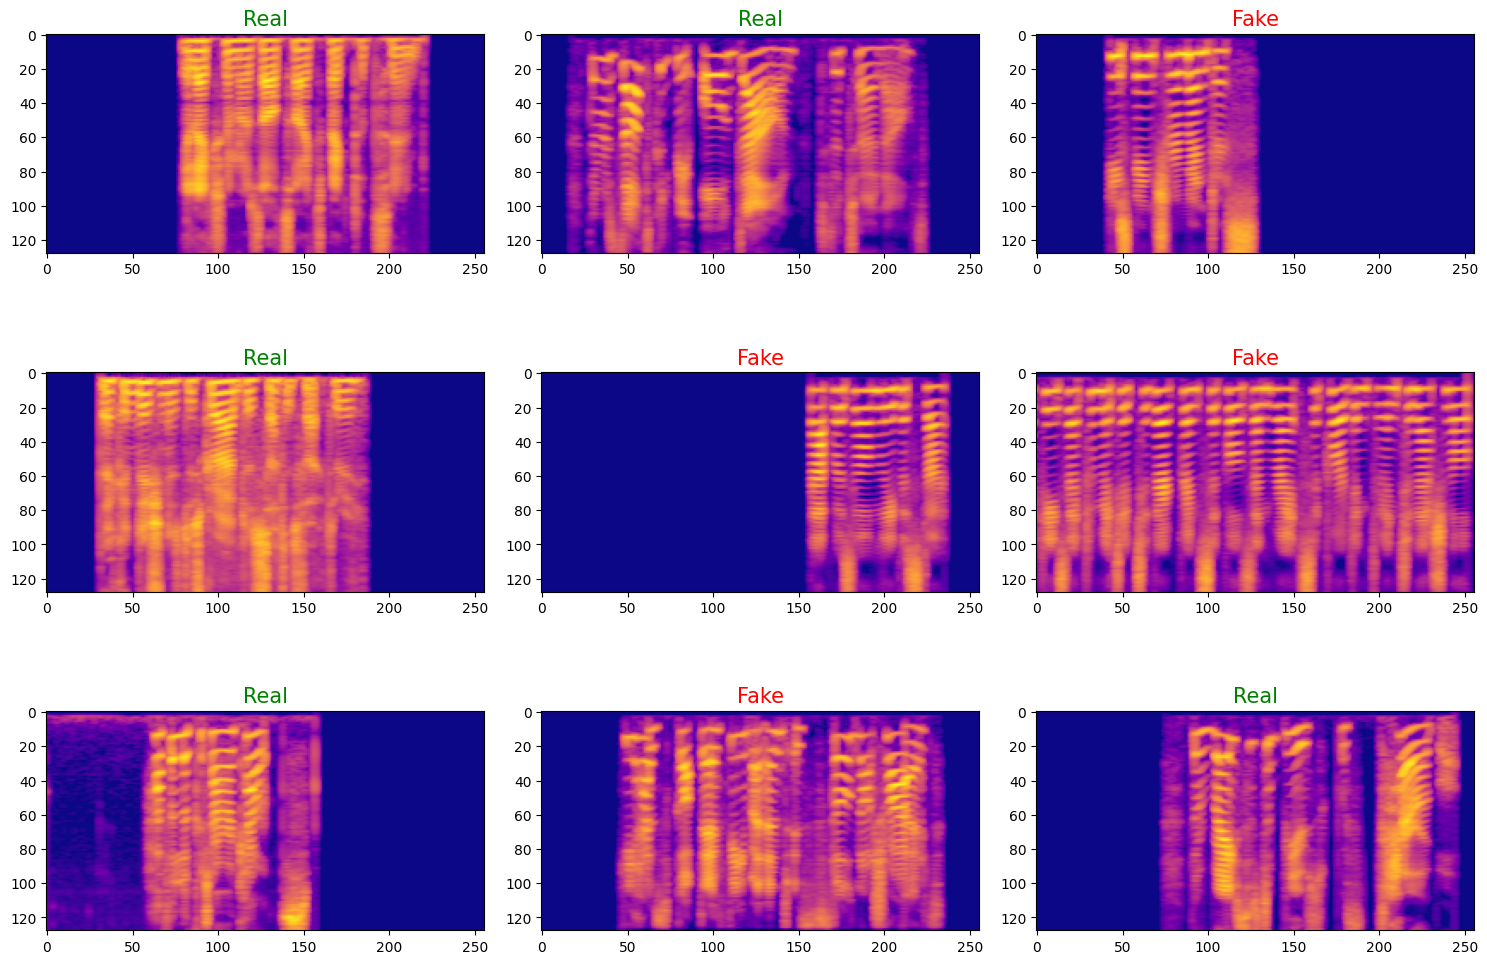

In [ ]:
ds = get_dataset(TRAIN_FILENAMES[:2], augment=False, cache=False, repeat=False).take(1)
batch = next(iter(ds.unbatch().batch(20)))
imgs, tars = batch
print(f'image_shape: {imgs.shape} target_shape:{tars.shape}')
print(f'image_dtype: {imgs.dtype} target_dtype:{tars.dtype}')
display_batch(batch, row=3, col=3)

With Augmentation

image_shape: (20, 256, 128, 1) target_shape:(20,)
image_dtype: <dtype: 'float32'> target_dtype:<dtype: 'float32'>


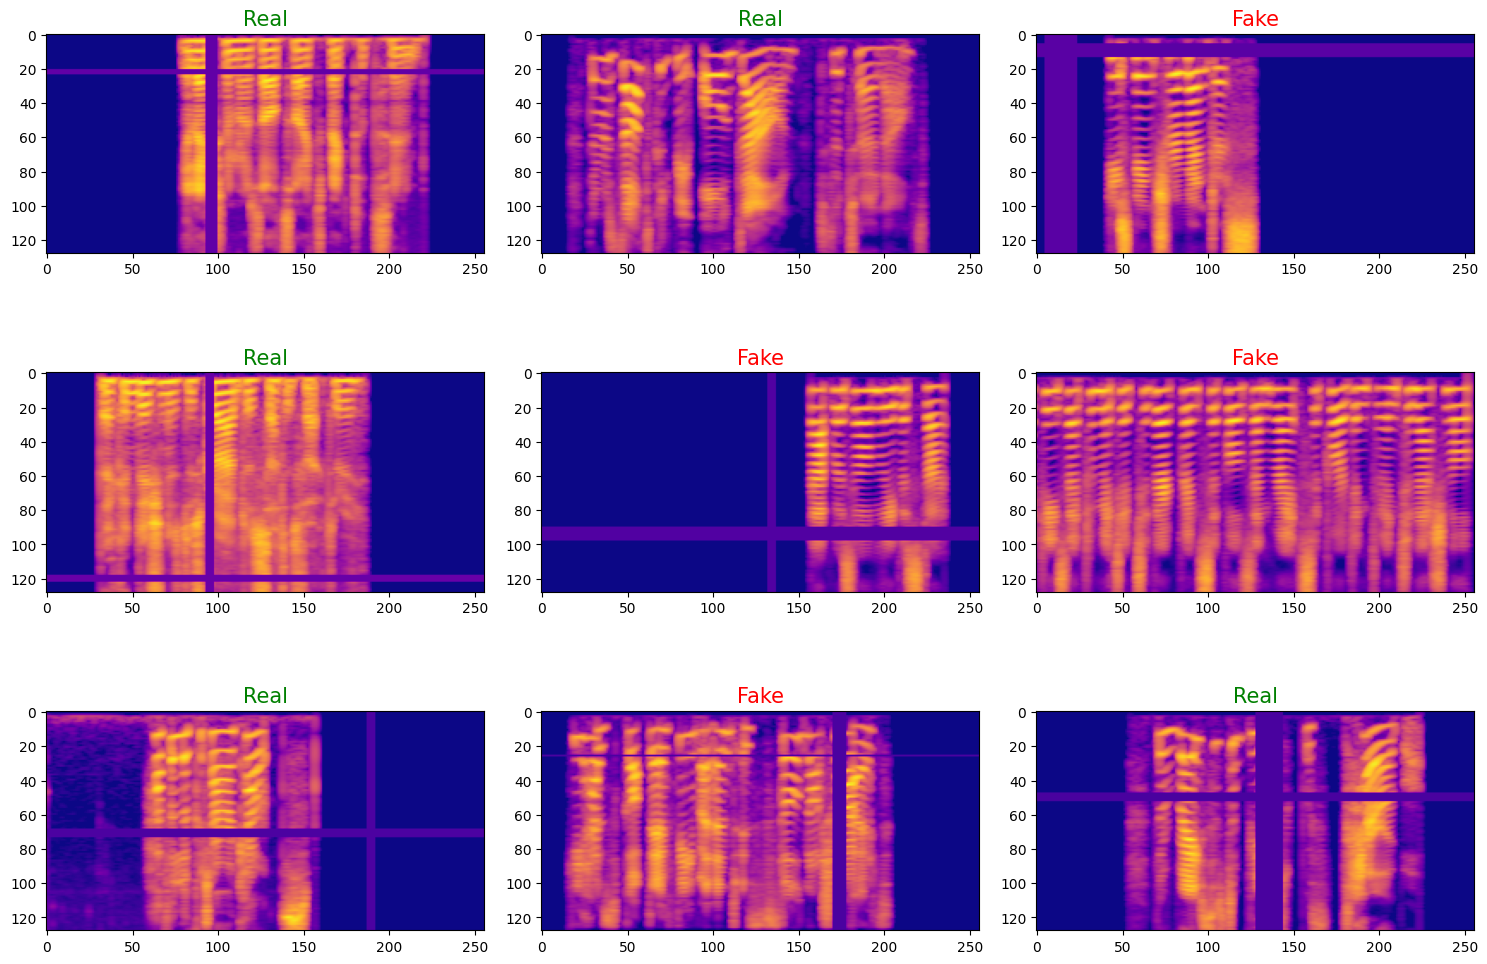

In [ ]:
ds = get_dataset(TRAIN_FILENAMES[:2], augment=True, cache=False, repeat=False).take(1)
batch = next(iter(ds.unbatch().batch(20)))
imgs, tars = batch
print(f'image_shape: {imgs.shape} target_shape:{tars.shape}')
print(f'image_dtype: {imgs.dtype} target_dtype:{tars.dtype}')
display_batch(batch, row=3, col=3)

Loss & Metric

In [ ]:
def get_metrics():
    acc = tf.keras.metrics.BinaryAccuracy()
    f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5, average='macro')
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    return [acc, precision, recall, f1_score]

LR Schedule

In [ ]:
import math

def get_lr_callback(mode='exp', batch_size=64, epochs=30, plot=False):
    """adapted from @cdeotte"""
    lr_start = 5e-5
    lr = 0.001 # base_lr
    lr_max = 5e-4 # max lr - will be multiplied by batch_size
    lr_min = 0.1e-4 # min lr
    lr_ramp_ep = 4 # warming up epochs
    lr_sus_ep = 0 # sustain epochs lr after warming up
    lr_decay = 0.8 # decay rate

    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        elif mode == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - \
                  lr_ramp_ep - lr_sus_ep) + lr_min

        elif mode == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

        elif mode == 'cosine':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(
            np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch')
        plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)

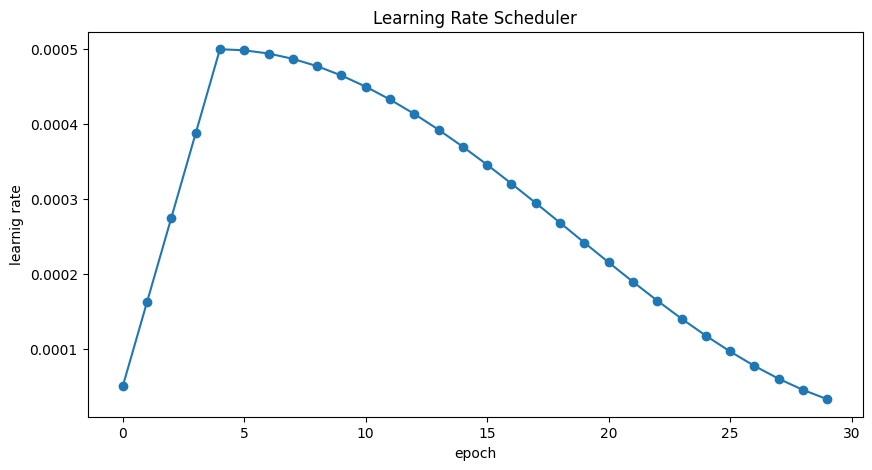

In [ ]:
lr_callback = get_lr_callback(mode=CFG.lr_schedule,epochs=30,plot=True)

Conformer

In [ ]:
import audio_classification_models as acm
model = acm.Conformer(input_shape=(128,80,1), pretrain=True)

35530456/35530456 [==============================] - 1s 0us/step


In [ ]:
import audio_classification_models as acm

LOCAL_WEIGHTS_PATH = '/content/drive/Othercomputers/My laptop/DS_10283_3336/conformer-encoder.h5'

def Conformer(input_shape=(128, 80, 1),num_classes=1, final_activation='sigmoid', pretrain=True):
    inp = tf.keras.layers.Input(shape=input_shape)
    backbone = acm.ConformerEncoder()
    out = backbone(inp)
    if pretrain:
        acm.utils.weights.load_pretrain(backbone, url=LOCAL_WEIGHTS_PATH)
    out = tf.keras.layers.GlobalAveragePooling1D()(out)
#     out = tf.keras.layers.Dense(32, activation='selu')(out)
    out = tf.keras.layers.Dense(num_classes, activation=final_activation)(out)
    model = tf.keras.models.Model(inp, out)
    return model

Build Model

In [ ]:
def get_model(name=CFG.model_name, loss=CFG.loss,):
    model = Conformer(input_shape=[*CFG.spec_shape,1],pretrain=True)
    lr = CFG.lr
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif CFG.optimizer == "AdamW":
        opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr)
    elif CFG.optimizer == "RectifiedAdam":
        opt = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    else:
        raise ValueError("Wrong Optimzer Name")
    model.compile(
        optimizer=opt,
        loss=loss,
        steps_per_execution=CFG.steps_per_execution, # to reduce idle time
        metrics=get_metrics()
    )
    return model

In [ ]:
model = get_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 128, 1)]     0         
                                                                 
 conformer_encoder (Conform  (None, None, 144)         8959680   
 erEncoder)                                                      
                                                                 
 global_average_pooling1d_1  (None, 144)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 145       
                                                                 
Total params: 8959825 (34.18 MB)
Trainable params: 8955217 (34.16 MB)
Non-trainable params: 4608 (18.00 KB)
_________________________________________________________________


Training

In [ ]:
# Load gcs_path of train, valid & test
TRAIN_FILENAMES = tf.io.gfile.glob('/content/drive/Othercomputers/My laptop/DS_10283_3336/tmp_PA/train*.tfrec')
VALID_FILENAMES = tf.io.gfile.glob('/content/drive/Othercomputers/My laptop/DS_10283_3336/tmp_PA/valid*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob('/content/drive/Othercomputers/My laptop/DS_10283_3336/tmp_PA/test*.tfrec')

# Take Only 10 Files if run in Debug Mode
if CFG.debug:
    TRAIN_FILENAMES = TRAIN_FILENAMES[:2]
    VALID_FILENAMES = VALID_FILENAMES[:2]
    TEST_FILENAMES = TEST_FILENAMES[:2]

# Shuffle train files
random.shuffle(TRAIN_FILENAMES)

# Count train and valid samples
NUM_TRAIN = count_data_items(TRAIN_FILENAMES)
NUM_VALID = count_data_items(VALID_FILENAMES)
NUM_TEST = count_data_items(TEST_FILENAMES)

In [ ]:
# Compute batch size & steps_per_epoch
BATCH_SIZE = CFG.batch_size * REPLICAS
STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE

print("#" * 60)
print("#### IMAGE_SIZE: (%i, %i) | BATCH_SIZE: %i | EPOCHS: %i"% (CFG.spec_shape[0],
                                                                  CFG.spec_shape[1],
                                                                  BATCH_SIZE,
                                                                  CFG.epochs))
print("#### MODEL: %s | LOSS: %s"% (CFG.model_name, CFG.loss))
print("#### NUM_TRAIN: {:,} | NUM_VALID: {:,}".format(NUM_TRAIN, NUM_VALID))
print("#" * 60)

############################################################
#### IMAGE_SIZE: (256, 128) | BATCH_SIZE: 32 | EPOCHS: 12
#### MODEL: Conformer | LOSS: binary_crossentropy
#### NUM_TRAIN: 5,000 | NUM_VALID: 4,000
############################################################


In [ ]:
# Build model in device
K.clear_session()
with strategy.scope():
    model = get_model(name=CFG.model_name,loss=CFG.loss)

In [ ]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/Othercomputers/My laptop/DS_10283_3336/ckpt.h5",
    verbose=CFG.verbose,
    monitor="val_f1_score",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)
callbacks = [checkpoint, get_lr_callback(mode=CFG.lr_schedule,epochs=CFG.epochs)]

In [ ]:
# Create train & valid dataset
train_ds = get_dataset(
    TRAIN_FILENAMES,
    augment=CFG.augment,
    batch_size=BATCH_SIZE,
    cache=False,
    drop_remainder=False,
)
valid_ds = get_dataset(
    VALID_FILENAMES,
    shuffle=False,
    augment=False,
    repeat=False,
    batch_size=BATCH_SIZE,
    cache=False,
    drop_remainder=False,
)

In [ ]:
# Increase batch size (adjust according to GPU memory)
BATCH_SIZE = CFG.batch_size * REPLICAS * 2

# Optimize data loading and preprocessing
train_ds = get_dataset(
    TRAIN_FILENAMES,
    augment=CFG.augment,
    batch_size=BATCH_SIZE,
    cache=True,  # Cache data for faster loading
    drop_remainder=True,  # Ensure batches have consistent size
)

# Simplify the model architecture if needed
with strategy.scope():
    model = get_model(name=CFG.model_name, loss=CFG.loss)

# Train model
history = model.fit(
    train_ds,
    epochs=CFG.epochs if not CFG.debug else 2,
    steps_per_epoch=STEPS_PER_EPOCH,
   # callbacks=callbacks,
    validation_data=valid_ds,
    verbose=CFG.verbose,
)


Performance


>> Valid Result:
63/63 [==============================] - 360s 5s/step - loss: 0.7507 - binary_accuracy: 0.8307 - precision_1: 0.7860 - recall_1: 0.9090 - f1_score: 0.8430


>> Test Result:
63/63 [==============================] - 343s 5s/step - loss: 0.6820 - binary_accuracy: 0.8447 - precision_1: 0.8133 - recall_1: 0.8950 - f1_score: 0.8522

62/62 [==============================] - 352s 5s/step


  0%|          | 0/4000 [00:00<?, ?it/s]


>> Confusoin Matrix


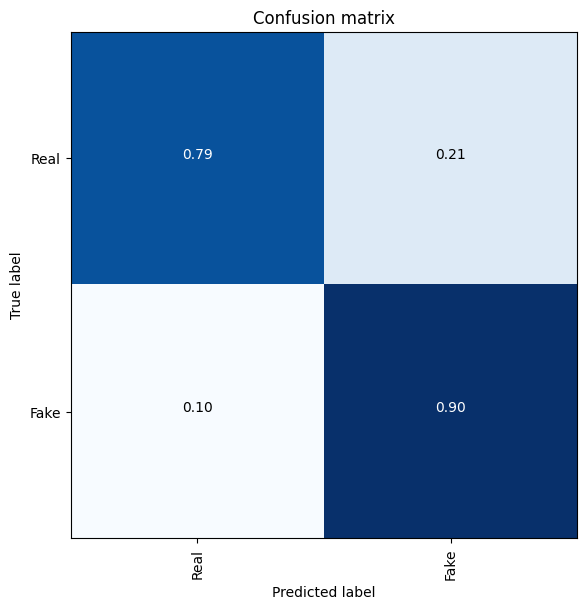

In [ ]:
# Load best weights
model.load_weights("/content/drive/Othercomputers/My laptop/DS_10283_3336/ckpt.h5")

# Compute & save best Test result
print("\n>> Valid Result:")
valid_result = model.evaluate(
    get_dataset(
        VALID_FILENAMES,
        batch_size=BATCH_SIZE,
        augment=False,
        shuffle=False,
        repeat=False,
        cache=False,
    ),
    return_dict=True,
    verbose=1,
)
print()

# Compute & save best Test result
print("\n>> Test Result:")
test_result = model.evaluate(
    get_dataset(
        TEST_FILENAMES,
        batch_size=BATCH_SIZE,
        augment=False,
        shuffle=False,
        repeat=False,
        cache=False,
    ),
    return_dict=True,
    verbose=1,
)
print()

# Get Prediction for test data
test_ds = get_dataset(TEST_FILENAMES,
    shuffle=False,
    augment=False,
    repeat=False,
    batch_size=BATCH_SIZE,
    cache=False,
    drop_remainder=False,
    return_id=False,
    return_label=False,
)
test_preds = model.predict(test_ds, verbose=1, steps=NUM_TEST/BATCH_SIZE)

# Extract test metadata from tfrecord
test_ds = get_dataset(TEST_FILENAMES,
    shuffle=False,
    augment=False,
    repeat=False,
    batch_size=1,
    cache=False,
    drop_remainder=False,
    return_id=True,
    return_label=True,
)
info = [(id_.numpy()[0].decode('utf-8'),label.numpy()[0]) for _,label,id_ in tqdm(iter(test_ds),total=NUM_TEST)]
test_ids, test_labels = list(zip(*info))

# Plot Confusion Matrix
print("\n>> Confusoin Matrix")
cm = confusion_matrix(test_labels, test_preds.reshape(-1).round())
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, ["Real","Fake"],normalize=True)